In [1]:
import pandas as pd
import numpy as np

pd.options.display.max_columns=None
pd.options.display.max_rows=None

In [2]:
path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data'
dataset = pd.read_csv(path, delimiter=' ', header=None)

In [3]:
dataset.shape

(1000, 21)

In [4]:
dataset.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,3,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,4,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,4,A124,53,A143,A153,2,A173,2,A191,A201,2


In [5]:
COL = [
    'Status_of_existing_checking_account', 
    'Duration_in_month',
    'Credit_history',
    'Purpose', 
    'Credit_amount', 
    'Savings_account_bonds', 
    'Present_employment_since', 
    'Installment_rate_in_percentage_of_disposable_income',
    'Personal_status_and_sex',
    'Other_debtors_guarantors',
    'Present_residence_since', 
    'Property', 
    'Age_in_years', 
    'Other_installment_plans', 
    'Housing',
    'Number_of_existing_credits_at_this_bank',
    'Job',
    'Number_of_people_being_liable_to_provide_maintenance_for',
    'Telephone',
    'foreign_worker',
    'Target'
]

In [6]:
dataset.columns = COL

In [7]:
dataset.head()

,Status_of_existing_checking_account,Duration_in_month,Credit_history,Purpose,Credit_amount,Savings_account_bonds,Present_employment_since,Installment_rate_in_percentage_of_disposable_income,Personal_status_and_sex,Other_debtors_guarantors,Present_residence_since,Property,Age_in_years,Other_installment_plans,Housing,Number_of_existing_credits_at_this_bank,Job,Number_of_people_being_liable_to_provide_maintenance_for,Telephone,foreign_worker,Target
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,3,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,4,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,4,A124,53,A143,A153,2,A173,2,A191,A201,2


In [8]:
# Label을 1/2 -> 0/1로 변경
dataset['Target'] = dataset['Target'] - 1

## 1. Information Value (정보 가치)
후진제거법 사용 이전에 변수 선택

예제)
0~50 dist of non-event = 197/3662
     dist of event = 20/338

WOE = ln(dist of Non-evnet/dist of event)

In [9]:
max_bin = 10  # 전체 데이터의 예측력에 해를 가하지 않는 한에서 구간을 테스트하였습니다.
def calc_iv(df, col, label, max_bin = max_bin):
    """IV helper function"""
    bin_df = df[[col, label]].copy()
    # Categorical column
    if bin_df[col].dtype == 'object':
        bin_df = bin_df.groupby(col)[label].agg(['count', 'sum'])
    # Numerical column
    else:
        bin_df.loc[:, 'bins'] = pd.qcut(bin_df[col].rank(method='first'), max_bin)
#         bin_df.loc[:, 'bins'] = pd.cut(bin_df[col], max_bin)
        bin_df = bin_df.groupby('bins')[label].agg(['count', 'sum'])
    
    bin_df.columns = ['total', 'abuse']
    bin_df['normal'] = bin_df['total'] - bin_df['abuse']
    bin_df['normal_dist'] = bin_df['normal'] / sum(bin_df['normal'])
    bin_df['abuse_dist'] = bin_df['abuse'] / sum(bin_df['abuse'])
    bin_df['woe'] = np.log(bin_df['normal_dist'] / bin_df['abuse_dist'])
    bin_df['iv'] = bin_df['woe'] * (bin_df['normal_dist'] - bin_df['abuse_dist'])
    
    bin_df.replace([np.inf, -np.inf], 0, inplace=True)
    bin_df = bin_df[bin_df['total'] > 0]
    iv_val = sum(filter(lambda x: x != float('inf'), bin_df['iv']))
    
    return bin_df, col, iv_val

In [10]:
ch_df, ch, ch_i_val = calc_iv(dataset,'Credit_history', 'Target')
ch_df

,total,abuse,normal,normal_dist,abuse_dist,woe,iv
Credit_history,,,,,,,
A30,40,25,15,0.021429,0.083333,-1.358123,0.084074
A31,49,28,21,0.030000,0.093333,-1.134980,0.071882
A32,530,169,361,0.515714,0.563333,-0.088319,0.004206
A33,88,28,60,0.085714,0.093333,-0.085158,0.000649
A34,293,50,243,0.347143,0.166667,0.733741,0.132423


In [11]:
dim_df, dim, dim_i_val = calc_iv(dataset,'Duration_in_month', 'Target')
dim_df

,total,abuse,normal,normal_dist,abuse_dist,woe,iv
bins,,,,,,,
"(0.999, 100.9]",100,11,89,0.127143,0.036667,1.243443,0.112502
"(100.9, 200.8]",100,20,80,0.114286,0.066667,0.538997,0.025667
"(200.8, 300.7]",100,27,73,0.104286,0.090000,0.147325,0.002105
"(300.7, 400.6]",100,25,75,0.107143,0.083333,0.251314,0.005984
"(400.6, 500.5]",100,26,74,0.105714,0.086667,0.198671,0.003784
"(500.5, 600.4]",100,38,62,0.088571,0.126667,-0.357750,0.013629
"(600.4, 700.3]",100,32,68,0.097143,0.106667,-0.093526,0.000891
"(700.3, 800.2]",100,31,69,0.098571,0.103333,-0.047179,0.000225
"(800.2, 900.1]",100,42,58,0.082857,0.140000,-0.524524,0.029973


In [12]:
# 높은 예측 능력
dim_i_val

0.2605225223321392

In [13]:
# 함수를 만들어서 전체 iv를 살펴보자
col_iv = {}
for col in [idx for idx in dataset.columns.tolist()]:
    if col == 'Target':
        continue
    _, col, iv = calc_iv(dataset, col, 'Target')
    col_iv[col] = iv

In [14]:
col_iv

{'Status_of_existing_checking_account': 0.6660115033513336,
 'Duration_in_month': 0.2605225223321392,
 'Credit_history': 0.2932335473908263,
 'Purpose': 0.16919506567307832,
 'Credit_amount': 0.11342803024552867,
 'Savings_account_bonds': 0.19600955690422672,
 'Present_employment_since': 0.086433631026641,
 'Installment_rate_in_percentage_of_disposable_income': 0.061554683786294126,
 'Personal_status_and_sex': 0.04467067763379073,
 'Other_debtors_guarantors': 0.032019322019485055,
 'Present_residence_since': 0.04874371881018562,
 'Property': 0.11263826240979674,
 'Age_in_years': 0.10267245670259074,
 'Other_installment_plans': 0.057614541955647885,
 'Housing': 0.08329343361549926,
 'Number_of_existing_credits_at_this_bank': 0.09779114631307396,
 'Job': 0.008762765707428294,
 'Number_of_people_being_liable_to_provide_maintenance_for': 0.03408883520785682,
 'Telephone': 0.0063776050286746735,
 'foreign_worker': 0.04387741201028899}

In [15]:
import operator
candidates = sorted(col_iv.items(), key=operator.itemgetter(1), reverse=True)
display(candidates)

[('Status_of_existing_checking_account', 0.6660115033513336),
 ('Credit_history', 0.2932335473908263),
 ('Duration_in_month', 0.2605225223321392),
 ('Savings_account_bonds', 0.19600955690422672),
 ('Purpose', 0.16919506567307832),
 ('Credit_amount', 0.11342803024552867),
 ('Property', 0.11263826240979674),
 ('Age_in_years', 0.10267245670259074),
 ('Number_of_existing_credits_at_this_bank', 0.09779114631307396),
 ('Present_employment_since', 0.086433631026641),
 ('Housing', 0.08329343361549926),
 ('Installment_rate_in_percentage_of_disposable_income', 0.061554683786294126),
 ('Other_installment_plans', 0.057614541955647885),
 ('Present_residence_since', 0.04874371881018562),
 ('Personal_status_and_sex', 0.04467067763379073),
 ('foreign_worker', 0.04387741201028899),
 ('Number_of_people_being_liable_to_provide_maintenance_for',
  0.03408883520785682),
 ('Other_debtors_guarantors', 0.032019322019485055),
 ('Job', 0.008762765707428294),
 ('Telephone', 0.0063776050286746735)]

In [16]:
# 분석하려는 feature의 갯수와 예측력의 trade-off를 조정하였습니다.
iv_cols = [key for key, iv in candidates if iv >= 0.044]
display(len(iv_cols))
display(sorted(iv_cols))

15

['Age_in_years',
 'Credit_amount',
 'Credit_history',
 'Duration_in_month',
 'Housing',
 'Installment_rate_in_percentage_of_disposable_income',
 'Number_of_existing_credits_at_this_bank',
 'Other_installment_plans',
 'Personal_status_and_sex',
 'Present_employment_since',
 'Present_residence_since',
 'Property',
 'Purpose',
 'Savings_account_bonds',
 'Status_of_existing_checking_account']

In [17]:
# 상수로 설정합니다.
IV_COL = iv_cols[:]

In [18]:
# Category column들은 one hot vectore로 변환합니다.
cate_features = {}
num_fetures = []
for col in IV_COL:
    if dataset[col].dtype == 'object':
        cate_features[col] = pd.get_dummies(dataset[col], prefix=col, drop_first=True)
    else:
        num_fetures.append(col)

In [19]:
cate_features.keys()

dict_keys(['Status_of_existing_checking_account', 'Credit_history', 'Savings_account_bonds', 'Purpose', 'Property', 'Present_employment_since', 'Housing', 'Other_installment_plans', 'Personal_status_and_sex'])

In [20]:
cate_features['Status_of_existing_checking_account'].head()

,Status_of_existing_checking_account_A12,Status_of_existing_checking_account_A13,Status_of_existing_checking_account_A14
0,0,0,0
1,1,0,0
2,0,0,1
3,0,0,0
4,0,0,0


In [21]:
removed_features = []

In [22]:
for col, dummies in cate_features.items():
    dropped_col = dummies.columns[-1]
    removed_features.append(dropped_col)
    cate_features[col] = dummies.drop(dropped_col, axis=1)

In [23]:
removed_features

['Status_of_existing_checking_account_A14',
 'Credit_history_A34',
 'Savings_account_bonds_A65',
 'Purpose_A49',
 'Property_A124',
 'Present_employment_since_A75',
 'Housing_A153',
 'Other_installment_plans_A143',
 'Personal_status_and_sex_A94']

In [24]:
cate_features['Status_of_existing_checking_account'].head()

,Status_of_existing_checking_account_A12,Status_of_existing_checking_account_A13
0,0,0
1,1,0
2,0,0
3,0,0
4,0,0


In [25]:
final_dataset = dataset[num_fetures]

In [26]:
for col, df in cate_features.items():
    final_dataset = pd.concat([final_dataset, df], axis=1)

In [27]:
final_dataset.shape

(1000, 31)

In [28]:
final_dataset.head()

,Duration_in_month,Credit_amount,Age_in_years,Number_of_existing_credits_at_this_bank,Installment_rate_in_percentage_of_disposable_income,Present_residence_since,Status_of_existing_checking_account_A12,Status_of_existing_checking_account_A13,Credit_history_A31,Credit_history_A32,Credit_history_A33,Savings_account_bonds_A62,Savings_account_bonds_A63,Savings_account_bonds_A64,Purpose_A41,Purpose_A410,Purpose_A42,Purpose_A43,Purpose_A44,Purpose_A45,Purpose_A46,Purpose_A48,Property_A122,Property_A123,Present_employment_since_A72,Present_employment_since_A73,Present_employment_since_A74,Housing_A152,Other_installment_plans_A142,Personal_status_and_sex_A92,Personal_status_and_sex_A93
0,6,1169,67,2,4,4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1
1,48,5951,22,1,2,2,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0
2,12,2096,49,1,2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1
3,42,7882,45,1,2,4,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1
4,24,4870,53,2,3,4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1


In [29]:
from sklearn.model_selection import train_test_split

In [30]:
train_x, test_x, train_y, test_y = \
    train_test_split( \
        final_dataset, dataset['Target'], test_size=0.2, random_state=42)

In [31]:
print('train_set', train_x.shape)
print('test_set', test_x.shape)

train_set (800, 31)
test_set (200, 31)


In [32]:
import statsmodels.api as sm

In [33]:
logistic_model = sm.Logit(
    train_y,
    sm.add_constant(train_x)
).fit()

Optimization terminated successfully.
         Current function value: 0.514623
         Iterations 6


/home/skkucman/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [34]:
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [35]:
train_pred = pd.DataFrame({
    'probs': logistic_model.predict(sm.add_constant(train_x)),
    'class': train_y
})

train_pred['y_pred'] = 0
train_pred.loc[train_pred['probs'] > 0.5, 'y_pred'] = 1

# Test prediction
test_pred = pd.DataFrame({
    'probs': logistic_model.predict(sm.add_constant(test_x)),
    'class': test_y
})

test_pred['y_pred'] = 0
test_pred.loc[test_pred['probs'] > 0.5, 'y_pred'] = 1

In [36]:
print('\nTraining Confusion matrix:')
display(pd.crosstab(train_pred['y_pred'], train_pred['class'], rownames=['Predict'], colnames=['Actual'], margins=True))
print('\nTraining Accuracy: ', round(accuracy_score(train_pred['class'], train_pred['y_pred']), 4))
print('\nTraining classification report:\n', classification_report(train_pred['class'], train_pred['y_pred'], digits=4))


Training Confusion matrix:


Actual,0,1,All
Predict,,,
0,509,150,659
1,50,91,141
All,559,241,800



Training Accuracy:  0.75

Training classification report:
               precision    recall  f1-score   support

           0     0.7724    0.9106    0.8358       559
           1     0.6454    0.3776    0.4764       241

   micro avg     0.7500    0.7500    0.7500       800
   macro avg     0.7089    0.6441    0.6561       800
weighted avg     0.7341    0.7500    0.7275       800



In [37]:
print('Test Confusion matrix:')
display(pd.crosstab(test_pred['y_pred'], test_pred['class'], rownames=['Predict'], colnames=['Actual'], margins=True))
print('\nTest Accuracy: ', round(accuracy_score(test_pred['class'], test_pred['y_pred']), 4))
print('\nTest classification report:\n', classification_report(test_pred['class'], test_pred['y_pred'], digits=4))

Test Confusion matrix:


Actual,0,1,All
Predict,,,
0,126,38,164
1,15,21,36
All,141,59,200



Test Accuracy:  0.735

Test classification report:
               precision    recall  f1-score   support

           0     0.7683    0.8936    0.8262       141
           1     0.5833    0.3559    0.4421        59

   micro avg     0.7350    0.7350    0.7350       200
   macro avg     0.6758    0.6248    0.6342       200
weighted avg     0.7137    0.7350    0.7129       200



In [38]:
unnecesarries = []

In [39]:
logistic_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                          Results: Logit
===================================================================================================
Model:                          Logit                       Pseudo R-squared:            0.159     
Dependent Variable:             Target                      AIC:                         887.3969  
Date:                           2019-04-24 21:13            BIC:                         1037.3044 
No. Observations:               800                         Log-Likelihood:              -411.70   
Df Model:                       31                          LL-Null:                     -489.54   
Df Residuals:                   768                         LLR p-value:                 1.5173e-18
Converged:                      1.0000                      Scale:                       1.0000    
No. Iterations:                 6.0000                                                             
---------------------------------------------------------------------------------------------------
                                                     Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------------------------------------------------------
const                                               -1.1131   0.7413 -1.5017 0.1332 -2.5660  0.3397
Duration_in_month                                    0.0265   0.0096  2.7664 0.0057  0.0077  0.0453
Credit_amount                                        0.0001   0.0000  2.2236 0.0262  0.0000  0.0002
Age_in_years                                        -0.0298   0.0095 -3.1513 0.0016 -0.0484 -0.0113
Number_of_existing_credits_at_this_bank              0.2706   0.1861  1.4545 0.1458 -0.0940  0.6353
Installment_rate_in_percentage_of_disposable_income  0.2672   0.0882  3.0306 0.0024  0.0944  0.4400
Present_residence_since                              0.0059   0.0878  0.0673 0.9464 -0.1661  0.1779
Status_of_existing_checking_account_A12              0.4112   0.1979  2.0783 0.0377  0.0234  0.7990
Status_of_existing_checking_account_A13             -0.1448   0.4015 -0.3607 0.7183 -0.9317  0.6421
Credit_history_A31                                   1.7155   0.4317  3.9734 0.0001  0.8693  2.5617
Credit_history_A32                                   0.5868   0.2382  2.4634 0.0138  0.1199  1.0536
Credit_history_A33                                   0.0138   0.3316  0.0417 0.9667 -0.6362  0.6639
Savings_account_bonds_A62                           -0.2098   0.2875 -0.7299 0.4655 -0.7733  0.3536
Savings_account_bonds_A63                           -0.6078   0.3889 -1.5627 0.1181 -1.3701  0.1545
Savings_account_bonds_A64                           -1.0729   0.5167 -2.0766 0.0378 -2.0856 -0.0603
Purpose_A41                                         -1.4668   0.3517 -4.1712 0.0000 -2.1560 -0.7776
Purpose_A410                                        -0.4502   0.7474 -0.6024 0.5469 -1.9152  1.0147
Purpose_A42                                         -0.5707   0.2553 -2.2358 0.0254 -1.0710 -0.0704
Purpose_A43                                         -0.9952   0.2322 -4.2863 0.0000 -1.4503 -0.5401
Purpose_A44                                         -0.2486   0.7108 -0.3498 0.7265 -1.6419  1.1446
Purpose_A45                                         -0.1774   0.5477 -0.3238 0.7461 -1.2509  0.8961
Purpose_A46                                          0.3340   0.3975  0.8402 0.4008 -0.4451  1.1131
Purpose_A48                                         -1.6780   1.1461 -1.4641 0.1432 -3.9244  0.5684
Property_A122                                        0.2848   0.2346  1.2139 0.2248 -0.1751  0.7447
Property_A123                                        0.2275   0.2081  1.0933 0.2743 -0.1803  0.6353
Present_employment_since_A72                         0.1528   0.2803  0.5452 0.5856 -0.3966  0.7023
Present_employment_since_A73                         0.0827   0.2331  0.3547 0.7228 -0.3742  0

In [40]:
def get_max_vif(df, removal_cols):
    vifs = []
    cnames = df.drop(removal_cols, axis=1).columns.tolist()
    for i in range(len(cnames)):
        xvar = cnames[:]
        yvar = xvar.pop(i)
        model = sm.OLS(
            df.drop(removal_cols, axis=1)[yvar], 
            sm.add_constant(df.drop(removal_cols, axis=1)[xvar]))
        res = model.fit()
        vif = 1 / (1 - res.rsquared)
        vifs.append((yvar, round(vif, 3)))
    vifs = sorted(vifs, key=operator.itemgetter(1), reverse=True)
    return vifs

In [41]:
vifs = get_max_vif(train_x, unnecesarries)

In [42]:
vifs

[('Personal_status_and_sex_A93', 2.553),
 ('Personal_status_and_sex_A92', 2.423),
 ('Credit_amount', 2.305),
 ('Duration_in_month', 1.892),
 ('Credit_history_A32', 1.817),
 ('Present_employment_since_A73', 1.63),
 ('Present_employment_since_A72', 1.609),
 ('Number_of_existing_credits_at_this_bank', 1.541),
 ('Present_employment_since_A74', 1.436),
 ('Purpose_A43', 1.396),
 ('Age_in_years', 1.391),
 ('Purpose_A42', 1.36),
 ('Property_A123', 1.345),
 ('Property_A122', 1.321),
 ('Present_residence_since', 1.313),
 ('Housing_A152', 1.296),
 ('Purpose_A41', 1.283),
 ('Installment_rate_in_percentage_of_disposable_income', 1.282),
 ('Credit_history_A33', 1.241),
 ('Credit_history_A31', 1.224),
 ('Status_of_existing_checking_account_A12', 1.117),
 ('Purpose_A410', 1.111),
 ('Purpose_A46', 1.109),
 ('Other_installment_plans_A142', 1.074),
 ('Purpose_A45', 1.073),
 ('Savings_account_bonds_A62', 1.067),
 ('Status_of_existing_checking_account_A13', 1.065),
 ('Purpose_A48', 1.057),
 ('Purpose_A44',

C통계량

실제 / 예측
1 / 0.92
0 / 0.34
0 / 0.12
1 / 0.4
1 / 0.64
0 / 0.82
1 / 0.84

실제 / 예측            실제 / 예측
1                     0 /
1                     0 / 
1                     0 / 
1

(Cartesian Product)
실제  /  예측      실제  /  예측     일치    불일치
1     /           0                   
                  0
                  0
1     /           0
                  0
                  0                         V
1     /           0
                  0                         V
                  0
1     /           0
                  0
                  0

%일치쌍 = 10/12 = 83.3%
%불일치 = 2/12 = 16.67

C = 0.5+ (%일치쌍 - %불일치쌍)/2

In [43]:
def get_c_stat(iv_pred):
    noraml_test_df = iv_pred[iv_pred['class'] == 0][['class', 'probs']]
    spammer_test_df = iv_pred[iv_pred['class'] == 1][['class', 'probs']]

    noraml_test_df['key'] = 0
    spammer_test_df['key'] = 0

    cross_join_df = noraml_test_df.merge(spammer_test_df, how='outer', on='key').drop('key', axis=1)

    cross_join_df['concordance'] = cross_join_df['probs_x'] < cross_join_df['probs_y']
    cross_join_df['in_concordance'] = cross_join_df['probs_x'] > cross_join_df['probs_y']
    cross_join_df['tie'] = cross_join_df['probs_x'] == cross_join_df['probs_y']

    results = cross_join_df.agg({'concordance': np.sum, 'in_concordance': np.sum, 'tie': np.sum}) / len(cross_join_df)
    c_stat = 0.5 + (results['concordance'] - results['in_concordance']) / 2
    
    return c_stat

In [44]:
def get_aic_value(model):
    return -2 * model.llf + 2 * (len(model.params) - 1)

In [45]:
c_stat, aic = get_c_stat(train_pred), get_aic_value(logistic_model)
print('c_stat:', c_stat)
print('aic:', aic)
print('loglikehood:', logistic_model.llf)

c_stat: 0.7628768028266243
aic: 885.3968510659702
loglikehood: -411.6984255329851


In [46]:
c_stat, aic = get_c_stat(test_pred), get_aic_value(logistic_model)
print('c_stat:', c_stat)
print('aic:', aic)
print('loglikehood:', logistic_model.llf)

c_stat: 0.6970789758384421
aic: 885.3968510659702
loglikehood: -411.6984255329851


In [47]:
# 2.3 : 1 정도는 imbalance 인가?
dataset.Target.value_counts()

0    700
1    300
Name: Target, dtype: int64

In [48]:
from sklearn.model_selection import train_test_split

In [49]:
train_set, test_set = train_test_split(dataset, test_size=0.3, random_state=42)

In [50]:
# 학습셋에서 비율 확인
train_set.Target.value_counts()

0    491
1    209
Name: Target, dtype: int64

In [51]:
# 테스트셋에서 비율 확인
test_set.Target.value_counts()

0    209
1     91
Name: Target, dtype: int64

In [52]:
num_features = []
cate_features = []
for feat in dataset.columns:
    if dataset[feat].dtype == 'object':
        cate_features.append(feat)
    elif feat != 'Target':
        num_features.append(feat)

In [53]:
num_features

['Duration_in_month',
 'Credit_amount',
 'Installment_rate_in_percentage_of_disposable_income',
 'Present_residence_since',
 'Age_in_years',
 'Number_of_existing_credits_at_this_bank',
 'Number_of_people_being_liable_to_provide_maintenance_for']

In [54]:
cate_features

['Status_of_existing_checking_account',
 'Credit_history',
 'Purpose',
 'Savings_account_bonds',
 'Present_employment_since',
 'Personal_status_and_sex',
 'Other_debtors_guarantors',
 'Property',
 'Other_installment_plans',
 'Housing',
 'Job',
 'Telephone',
 'foreign_worker']

In [55]:
# Minmax를 선택하겠다. 왜?  Feature간 
from sklearn.preprocessing import MinMaxScaler

In [56]:
# Null 값 체크
train_set[num_features].describe()

,Duration_in_month,Credit_amount,Installment_rate_in_percentage_of_disposable_income,Present_residence_since,Age_in_years,Number_of_existing_credits_at_this_bank,Number_of_people_being_liable_to_provide_maintenance_for
count,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000
mean,21.252857,3406.815714,2.981429,2.834286,35.492857,1.420000,1.137143
std,11.900051,2971.897408,1.118679,1.103238,11.253037,0.581695,0.344244
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1381.750000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2332.000000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,4226.000000,4.000000,4.000000,42.000000,2.000000,1.000000
max,60.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


In [57]:
scaler = MinMaxScaler()
scaler.fit(train_set[num_features])

/home/skkucman/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


MinMaxScaler(copy=True, feature_range=(0, 1))

fit_transform이 있지만 각각 나눠서 하는 이유는 테스트셋의 MinMax를 train셋의 기준으로 적용하기 위함

In [58]:
train_scaled_num_features = scaler.transform(train_set[num_features])
test_scaled_num_features = scaler.transform(test_set[num_features])

In [59]:
# align 작동법
df1 = pd.DataFrame([[1,2,3,4], [6,7,8,9]], columns=['D', 'B', 'E', 'A'], index=[1,2])
df2 = pd.DataFrame([[10,20,30,40], [60,70,80,90], [600,700,800,900]], columns=['A', 'B', 'C', 'D'], index=[2,3,4])

display(df1)
display(df2)

a1, a2 = df1.align(df2, join='outer', axis=1)
display(a1)
display(a2)



,D,B,E,A
1,1,2,3,4
2,6,7,8,9


,A,B,C,D
2,10,20,30,40
3,60,70,80,90
4,600,700,800,900


,A,B,C,D,E
1,4,2,NaN,1,3
2,9,7,NaN,6,8


,A,B,C,D,E
2,10,20,30,40,NaN
3,60,70,80,90,NaN
4,600,700,800,900,NaN


### 카테고리 데이터의 경우 테스트셋과 트레이닝셋의 One-hot-vector변경시 양쪽 컬럼을 맞추기 위해

In [62]:
train_cat_features = pd.get_dummies(train_set[cate_features], drop_first=True)
print(train_cat_features.shape)
train_cat_features.head(1)

(700, 41)


,Status_of_existing_checking_account_A12,Status_of_existing_checking_account_A13,Status_of_existing_checking_account_A14,Credit_history_A31,Credit_history_A32,Credit_history_A33,Credit_history_A34,Purpose_A41,Purpose_A410,Purpose_A42,Purpose_A43,Purpose_A44,Purpose_A45,Purpose_A46,Purpose_A48,Purpose_A49,Savings_account_bonds_A62,Savings_account_bonds_A63,Savings_account_bonds_A64,Savings_account_bonds_A65,Present_employment_since_A72,Present_employment_since_A73,Present_employment_since_A74,Present_employment_since_A75,Personal_status_and_sex_A92,Personal_status_and_sex_A93,Personal_status_and_sex_A94,Other_debtors_guarantors_A102,Other_debtors_guarantors_A103,Property_A122,Property_A123,Property_A124,Other_installment_plans_A142,Other_installment_plans_A143,Housing_A152,Housing_A153,Job_A172,Job_A173,Job_A174,Telephone_A192,foreign_worker_A202
541,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0


In [66]:
test_cat_features = pd.get_dummies(test_set[cate_features],drop_first=True)
print(test_cat_features.shape)
test_cat_features.head(1)

(300, 41)


,Status_of_existing_checking_account_A12,Status_of_existing_checking_account_A13,Status_of_existing_checking_account_A14,Credit_history_A31,Credit_history_A32,Credit_history_A33,Credit_history_A34,Purpose_A41,Purpose_A410,Purpose_A42,Purpose_A43,Purpose_A44,Purpose_A45,Purpose_A46,Purpose_A48,Purpose_A49,Savings_account_bonds_A62,Savings_account_bonds_A63,Savings_account_bonds_A64,Savings_account_bonds_A65,Present_employment_since_A72,Present_employment_since_A73,Present_employment_since_A74,Present_employment_since_A75,Personal_status_and_sex_A92,Personal_status_and_sex_A93,Personal_status_and_sex_A94,Other_debtors_guarantors_A102,Other_debtors_guarantors_A103,Property_A122,Property_A123,Property_A124,Other_installment_plans_A142,Other_installment_plans_A143,Housing_A152,Housing_A153,Job_A172,Job_A173,Job_A174,Telephone_A192,foreign_worker_A202
521,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0


In [67]:
train_cat_features, test_cat_features = \
    train_cat_features.align(test_cat_features, join='outer', axis=1, fill_value=0)

In [68]:
print(train_cat_features.shape)
print(test_cat_features.shape)

(700, 54)
(300, 54)


In [69]:
train_x = np.c_[train_scaled_num_features, train_cat_features]
test_x = np.c_[test_scaled_num_features, test_cat_features]
train_y = train_set['Target']
test_y = test_set['Target']
print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(700, 61)
(300, 61)
(700,)
(300,)


In [70]:
from sklearn.linear_model import LogisticRegression

In [71]:
logistic = LogisticRegression(random_state=42)

In [72]:
from sklearn.model_selection import cross_val_score
cross_val_score(logistic, train_x, train_y, cv=3, scoring='accuracy')

/home/skkucman/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/skkucman/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/skkucman/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([0.73931624, 0.6965812 , 0.72413793])

In [75]:
from sklearn.model_selection import cross_val_predict

pred_train_y = cross_val_predict(logistic, train_x, train_y, cv=3)

/home/skkucman/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/skkucman/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/skkucman/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [77]:
from sklearn.model_selection import cross_val_predict

pred_train_y = cross_val_predict(logistic, train_x, train_y, cv=3)

/home/skkucman/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/skkucman/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/skkucman/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [78]:
from sklearn.metrics import precision_score, recall_score

precision = precision_score(train_y, pred_train_y)
recall = recall_score(train_y, pred_train_y)
print('Precision :', precision)
print('Recall :', recall)

Precision : 0.543046357615894
Recall : 0.3923444976076555


In [79]:
y_scores = cross_val_predict(logistic, train_x, train_y, cv=3, method='predict_proba') 

/home/skkucman/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/skkucman/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/skkucman/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [80]:
y_scores[:5]

array([[0.78996217, 0.21003783],
       [0.88143696, 0.11856304],
       [0.60844113, 0.39155887],
       [0.89804317, 0.10195683],
       [0.96898155, 0.03101845]])

In [81]:
from sklearn.metrics import precision_recall_curve

# 1의 확률만 넣기 위하여 y_scores[:, 1]를 사용합니다.
precisions, recalls, thresholds = precision_recall_curve(train_y, y_scores[:,1])

In [83]:
import numpy as np
import matplotlib.pyplot as plt

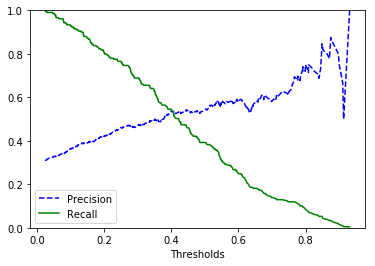

In [84]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Thresholds')
    plt.legend(loc='lower left')
    plt.ylim([0, 1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [85]:
logistic.fit(train_x, train_y)

/home/skkucman/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [86]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [87]:
accuracy = accuracy_score(logistic.predict(test_x), test_y)
print('Accuracy :', accuracy)

Accuracy : 0.7833333333333333


In [88]:
print(classification_report(test_y, logistic.predict(test_x)))

              precision    recall  f1-score   support

           0       0.80      0.91      0.85       209
           1       0.71      0.48      0.58        91

   micro avg       0.78      0.78      0.78       300
   macro avg       0.76      0.70      0.71       300
weighted avg       0.77      0.78      0.77       300



In [89]:
pd.crosstab(logistic.predict(test_x), test_y, 
            rownames=['Predict'], colnames=['Actual'], margins=True)

Actual,0,1,All
Predict,,,
0,191,47,238
1,18,44,62
All,209,91,300


In [90]:
logistic.predict_proba(test_x)[:10]

array([[0.61492601, 0.38507399],
       [0.50184087, 0.49815913],
       [0.39497356, 0.60502644],
       [0.70487598, 0.29512402],
       [0.94620022, 0.05379978],
       [0.65980966, 0.34019034],
       [0.92808692, 0.07191308],
       [0.57912408, 0.42087592],
       [0.95423086, 0.04576914],
       [0.94978428, 0.05021572]])

 $s_k(x)=(\theta^{(k)})^Tx$
 
 1\b
 $x
 
 1            C_1
 
$ x_1          C_2
 
 x_2          C_3
 theta
 S1(x) = theta_10+theta_11x_1+theta_12 X_2
 S2(x) = theta_20+theta_21x_1+theta_22 X_2
 S3(x) = .....
 
 
 
Hat(P)_k = exp(s_k(X))/(sigma(j=1 to K) (S_j(X))

## cross-val-predict CV3의 경우 각 V셋의 predict로 전체 셋 구성
## cross-val-score Cv3의 각 V셋의 Predict 후 각 CV_k에 대한 평 및 std비교

로지스틱에서 Loss Fuction
1. 오류율
2. Cross Entrop
 2번에서 Cross Entropy를 구하기 위해 소프트맥스 함수의 log의 식
 softㅡㅁ

In [92]:
from sklearn import datasets
iris = datasets.load_iris()

# 데이터셋의 내부구조를 보려면..
list(iris.keys())

['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename']

In [93]:
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

In [94]:
# Softmax classifier의 동작을 살펴보기 위하여, scaling은 우선 무시 (데이터의 양도 적다.)
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size = 0.3, random_state=42)

In [95]:
train_x[:3]

array([[3.7, 1. ],
       [5.1, 1.5],
       [5.5, 1.8]])

In [96]:
train_y[:3]

array([1, 2, 2])

In [97]:
softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10, random_state=42)
softmax_reg.fit(train_x, train_y)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=42, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [98]:
accuracy_score(train_y, softmax_reg.predict(train_x))

0.9523809523809523

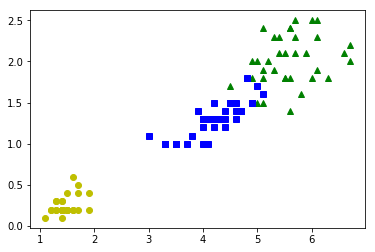

In [99]:
plt.plot(train_x[train_y==2, 0], train_x[train_y==2, 1], "g^", label="Iris-Virginica")
plt.plot(train_x[train_y==1, 0], train_x[train_y==1, 1], "bs", label="Iris-Versicolor")
plt.plot(train_x[train_y==0, 0], train_x[train_y==0, 1], "yo", label="Iris-Setosa")

In [100]:
accuracy_score(test_y, softmax_reg.predict(test_x))

1.0

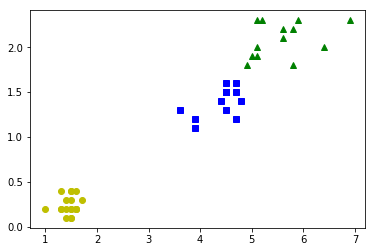

In [101]:
plt.plot(test_x[test_y==2, 0], test_x[test_y==2, 1], "g^", label="Iris-Virginica")
plt.plot(test_x[test_y==1, 0], test_x[test_y==1, 1], "bs", label="Iris-Versicolor")
plt.plot(test_x[test_y==0, 0], test_x[test_y==0, 1], "yo", label="Iris-Setosa")

In [102]:
sample = train_x[0]
sample

array([3.7, 1. ])

In [103]:
print('Sample이 속한 클래스 :', train_y[0])

Sample이 속한 클래스 : 1


In [104]:
softmax_reg.coef_

array([[-4.20766609, -2.03386207],
       [ 0.2548296 , -1.76288787],
       [ 3.95283649,  3.79674994]])

In [105]:
class_0_theta = softmax_reg.coef_[0]
class_1_theta = softmax_reg.coef_[1]
class_2_theta = softmax_reg.coef_[2]

In [106]:
softmax_reg.intercept_

array([ 16.87489499,   5.12511697, -22.00001196])

In [107]:
a = np.dot(class_0_theta, sample) + softmax_reg.intercept_[0]
b = np.dot(class_1_theta, sample) + softmax_reg.intercept_[1]
c = np.dot(class_2_theta, sample) + softmax_reg.intercept_[2]

In [108]:
print('첫번째 클래스의 소프트맥스 점수 :', a)
print('두번째 클래스의 소프트맥스 점수 :', b)
print('세번째 클래스의 소프트맥스 점수 :', c)

첫번째 클래스의 소프트맥스 점수 : -0.7273316266552214
두번째 클래스의 소프트맥스 점수 : 4.30509861767149
세번째 클래스의 소프트맥스 점수 : -3.5777669910174623


In [111]:
# Softmax classifier에서 해당값을 찾아볼수 있다.
softmax_reg.decision_function(train_x)[0]

array([-0.72733163,  4.30509862, -3.57776699])

In [112]:
# 직접 구해보는 것
print('첫번째 클래스의 소프트맥스 값 :', np.exp(a) / (np.exp(a) + np.exp(b) + np.exp(c)))
print('두번째 클래스의 소프트맥스 값 :', np.exp(b) / (np.exp(a) + np.exp(b) + np.exp(c)))
print('세번째 클래스의 소프트맥스 값 :', np.exp(c) / (np.exp(a) + np.exp(b) + np.exp(c)))

첫번째 클래스의 소프트맥스 값 : 0.006478238530079108
두번째 클래스의 소프트맥스 값 : 0.9931471952699612
세번째 클래스의 소프트맥스 값 : 0.00037456619995968597


In [113]:
# 소프트맥스 클래스를 호출
from sklearn.utils.extmath import softmax
softmax([[a, b, c]])

array([[6.47823853e-03, 9.93147195e-01, 3.74566200e-04]])

In [114]:
# Softmax classifier에서 해당값을 찾아볼수 있다.
softmax_reg.predict_proba(train_x)[0]

array([6.47823853e-03, 9.93147195e-01, 3.74566200e-04])